<a href="https://colab.research.google.com/github/deerow22/EscapeEarth/blob/main/Interns/Danielle/EBremoval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## mount google drive to access files

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
## typical imports
%matplotlib inline
!pip install lightkurve==1.9.0 #b/c non-standard library & we want a specific version
import lightkurve as lk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from astroquery.mast import Catalogs

In [ ]:
#trying to see our sample size evolution

#load datafiles
main = pd.read_csv('/content/gdrive/My Drive/EscapeEarthData/main_df.csv') #bls stats from 14 & 15
targets14 = pd.read_csv('/content/gdrive/My Drive/EscapeEarthData/all_targets_S014_v1.csv',skiprows = 5)
targets15 = pd.read_csv('/content/gdrive/My Drive/EscapeEarthData/all_targets_S015_v1.csv',skiprows= 5)
final_candidates = pd.read_csv('/content/gdrive/My Drive/EscapeEarthData/final_candidates.csv')
final_planets = pd.read_csv('/content/gdrive/My Drive/EscapeEarthData/final_final_candidates.csv')


#manipulate dfs
alltargets = pd.concat([targets14,targets15]) #all lightcurves (even for duplicate targets)
dupetargets = pd.merge(targets14,targets15,on='TICID') #targets observed in both sectors
unqs = alltargets['TICID'].unique() #all unique targets
print('number of targets observed in Sectors 14 & 15:',len(dupetargets))
print('number of targets observed in only one Sector (14 or 15):',len(unqs) - len(dupetargets))
print('Total number of unique targets:',len(unqs))
print('total number of data files (light curves):',len(alltargets))

#get temps for tempcut
catalog_data = Catalogs.query_criteria(catalog='Tic', ID = unqs) 
catalog_df = catalog_data.to_pandas()
sample_start = catalog_df #unique targets b/c fed in unqs list
sample_tempcut = catalog_df[catalog_df['Teff']<6500] #unique targets b/c fed in unqs list

#merge with main to get bls cut after teff cut
catalog_df['ID'] = catalog_df['ID'].astype(int) #change str to match int in alltargets
merged = pd.merge(alltargets, catalog_df, left_on ='TICID',right_on='ID') #give all lcs a temp
merged2 = merged[merged['Teff']<6500] #redo temp cut 
sanitycheck_temp = merged2['TICID'].unique() #this should match sample_tempcut
print('these should match:',len(sample_tempcut),len(sanitycheck_temp),'otherwise check tempcut')
merged3 = pd.merge(merged2,main, left_on='TICID',right_on='TIC') #give tempcut bls stats

#bls cut
bls_cut1 = merged3['Power']>50 
bls_cut2 = merged3['Duration']<0.125
blscut = merged3[(bls_cut1) & (bls_cut2)] #includes multiple observations of same star
sample_blscut = blscut['TIC'].unique() #get unique targets only b/c will be transits in both observed sectors

#giant removal
sample_final = final_candidates['ID'].unique() #this is from mast so unique by nature

#final number of light curves
mask = np.isin(main['TIC'].to_numpy(), sample_final)
lc_end = main[mask]

#final number of exoplanet-host candidates
final_final = final_planets['TIC'].unique()

#make variable names more meaningful
lc_start = alltargets
lc_end = lc_end
#make these equal to dataframes so temp is accessible
start_df = catalog_df
tempcut_df = sample_tempcut
blscut_df = Catalogs.query_criteria(catalog='Tic', ID = sample_blscut) #need to add temps
final_df = Catalogs.query_criteria(catalog='Tic', ID = sample_final) #need to add temps




print('\nEvolution of sample reduction:')
print('starting:', len(sample_start),'\ntempcut:',len(sample_tempcut),'\nblscut:',len(sample_blscut),'\ngiantcut:',len(sample_final),'\nfinal:',len(final_final))
print('\nStarted with {} light curves and reduced to {} lightcurves'.format(len(lc_start),len(lc_end)))
print('Started with {} unique targets and reduced to {} exoplanet hosting candidate targets'.format(len(sample_start),len(sample_final)))

number of targets observed in Sectors 14 & 15: 12094
number of targets observed in only one Sector (14 or 15): 15812
Total number of unique targets: 27906
total number of data files (light curves): 40000
these should match: 22789 22789 otherwise check tempcut

Evolution of sample reduction:
starting: 27906 
tempcut: 22789 
blscut: 244 
giantcut: 149 
final: 8

Started with 40000 light curves and reduced to 221 lightcurves
Started with 27906 unique targets and reduced to 149 exoplanet hosting candidate targets


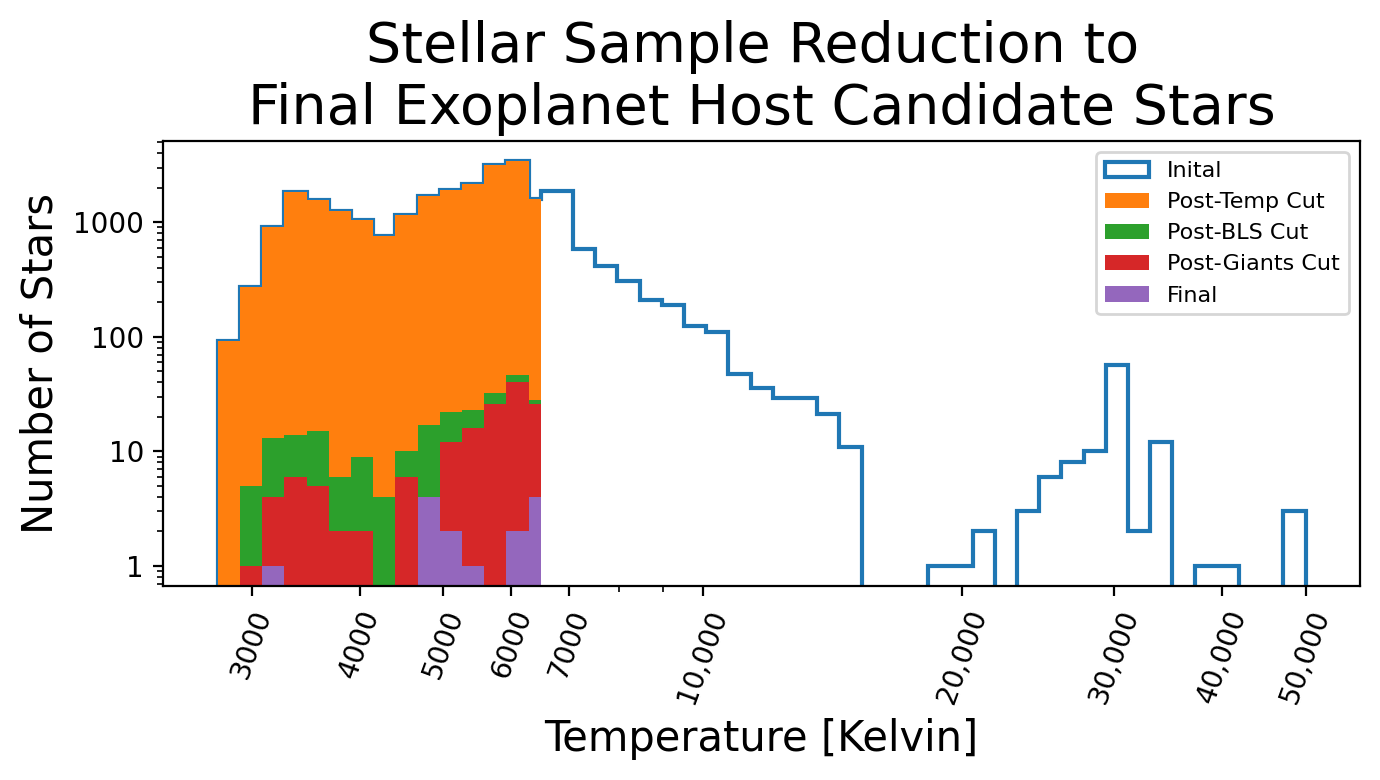

In [ ]:
#histogram of sample reduction
%matplotlib inline

start_temps = start_df['Teff'].to_numpy()
tempcut_temps = tempcut_df['Teff'].to_numpy()
blscut_temps = blscut_df['Teff'] #.to_numpy()
final_temps = final_df['Teff'] #.to_numpy()
FINAL_temps = final_planets['Teff'].to_numpy() #real final


#info needed for iterating to make plot
myarrs = [start_temps, tempcut_temps, blscut_temps, final_temps, FINAL_temps]
# bins1=np.logspace(np.log10(min(start_temps)),np.log10(max(start_temps)), 50)
bins2=np.logspace(np.log10(2700),np.log10(7000), 50)
bins1 = [ 2740.        ,  2907.29924225,  3084.8134613 ,  3273.16636442,
        3473.01974125,  3685.07578907,  3910.07957999,  4148.82167885,
        4402.14092085,  4670.92735892,  4956.12539095,  5258.73707795,
        5579.82566492,  5920.51931661,  6282.01508134,  6500  ,
        7072.57105366,  7504.40892885,  7962.61401181,  8448.79623461,
        8964.66382875,  9512.02932712, 10092.81593247, 10709.06427468,
       11362.93958064, 12056.73928193, 12792.90108697, 13574.01154609,
       14402.81513949, 15282.22392017, 16215.3277456 , 17205.40513415,
       18255.93478433, 19370.60779744, 20553.34064648, 21808.28893692,
       23139.86200767, 24552.73842357, 26051.88241384, 27642.56131419,
       29330.3640739 , 31121.22089302, 33021.42405842, 35037.65005217,
       37176.98300978, 39446.93961071, 41855.49548875, 44411.11325485,
       47122.77223109, 50000.        ]
names =['Inital','Post-Temp Cut','Post-BLS Cut','Post-Giants Cut','Final']

plt.figure(figsize=(7,4),dpi=200)
for count,arr in enumerate(myarrs):
  if count ==0:
    plt.hist(arr,bins=bins1,label=names[count],histtype='step',lw=1.5) #makes easier to see behind all other data
  else:
    plt.hist(arr,bins=bins1,label=names[count],histtype ='stepfilled')
# plt.xlim(7000, 2000) #if want in usual cmd view
plt.legend(fontsize=8);plt.xscale('log');plt.yscale('log')
#change ticks for readability 
plt.yticks(ticks=([1, 10, 100, 1000]),
           labels=['1', '10', '100', '1000'])
plt.xticks(ticks=([3E3, 4E3, 5E3, 6E3,7E3, 1E4, 2E4,3E4,4E4,5E4]),
           labels=['3000', '4000', '5000', '6000','7000','10,000','20,000','30,000','40,000','50,000'],rotation=70)
plt.ylabel('Number of Stars',fontsize=15); plt.xlabel('Temperature [Kelvin]',fontsize=15)
plt.title('Stellar Sample Reduction to \nFinal Exoplanet Host Candidate Stars',fontsize=20);
plt.tight_layout()
#save---already ran
# plt.savefig('/content/gdrive/My Drive/EscapeEarthData/SampleReduction_Plot.png',dpi=200)

In [ ]:
np.logspace(np.log10(min(start_temps)),np.log10(max(start_temps)), 50) #to make bins similar, had to change 6665.583097 to 6500 to match temp cut



array([ 2740.        ,  2907.29924225,  3084.8134613 ,  3273.16636442,
        3473.01974125,  3685.07578907,  3910.07957999,  4148.82167885,
        4402.14092085,  4670.92735892,  4956.12539095,  5258.73707795,
        5579.82566492,  5920.51931661,  6282.01508134,  6665.583097  ,
        7072.57105366,  7504.40892885,  7962.61401181,  8448.79623461,
        8964.66382875,  9512.02932712, 10092.81593247, 10709.06427468,
       11362.93958064, 12056.73928193, 12792.90108697, 13574.01154609,
       14402.81513949, 15282.22392017, 16215.3277456 , 17205.40513415,
       18255.93478433, 19370.60779744, 20553.34064648, 21808.28893692,
       23139.86200767, 24552.73842357, 26051.88241384, 27642.56131419,
       29330.3640739 , 31121.22089302, 33021.42405842, 35037.65005217,
       37176.98300978, 39446.93961071, 41855.49548875, 44411.11325485,
       47122.77223109, 50000.        ])

In [ ]:
#planet radii calculation fcn

def planet_radii(depth, star_radius):
    import math as m
    R_Sun = 696340000 #m
    R_Earth = 6371000 #m
    r_star = star_radius * R_Sun #b/c in R_Sun units
    radius = r_star * m.sqrt(depth) 
    r_planet = radius / R_Earth #b/c need in R_Earth
    return r_planet

In [ ]:
## import our custom modules

import sys
sys.path.append('/content/gdrive/My Drive/EscapeEarthData/')
import LCAnalysis_test as lca

In [ ]:
candidates = pd.read_csv('/content/gdrive/My Drive/EscapeEarthData/final_candidates.csv')
candidates

,ID,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,APASS,KIC,objType,typeSrc,ra,dec,POSflag,pmRA,e_pmRA,pmDEC,e_pmDEC,PMflag,plx,e_plx,PARflag,gallong,gallat,eclong,eclat,Bmag,e_Bmag,Vmag,e_Vmag,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,...,duplicate_id,priority,eneg_EBV,epos_EBV,EBVflag,eneg_Mass,epos_Mass,eneg_Rad,epos_Rad,eneg_rho,epos_rho,eneg_logg,epos_logg,eneg_lum,epos_lum,eneg_dist,epos_dist,distflag,eneg_Teff,epos_Teff,TeffFlag,gaiabp,e_gaiabp,gaiarp,e_gaiarp,gaiaqflag,starchareFlag,VmagFlag,BmagFlag,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,objID,ABS Mag
0,26584043,20190415,NaN,3551-00183-1,695-066800,19281062+4856369,NaN,J192810.61+485636.0,2129722038386345472,54443748.0,11244501.0,STAR,tmgaia2,292.044285,48.943530,tmgaia2,-8.63573,0.045241,-66.23690,0.043199,gaia2,9.44595,0.023352,gaia2,80.884833,14.509196,313.629043,69.067209,10.646,0.065,9.935,0.005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.004684,0.001545,0.002819,panstarrs,0.121205,0.129359,0.039780,0.092235,0.143803,0.218956,0.070150,0.103765,0.026203,0.023051,0.2620,0.2620,bj2018,147.7530,139.740,spect,10.27840,0.005166,9.28557,0.004795,1,NaN,tycho2v3,tycho2b3,NaN,0.770690,0.670026,292.044228,48.943245,0.019350,0.024440,1,0,288792450,4.718098
1,26656583,20190415,NaN,3564-01688-1,698-069158,19301822+4931325,NaN,J193018.24+493133.2,2129813469650632064,54446097.0,11560447.0,STAR,tmgaia2,292.575961,49.525712,tmgaia2,15.61760,0.053184,62.78720,0.046020,gaia2,7.93962,0.031862,gaia2,81.581227,14.439999,315.216611,69.445791,11.679,0.139,11.096,0.009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.002801,0.003669,0.003956,panstarrs,0.097937,0.146821,0.057792,0.040721,0.470629,0.383539,0.090284,0.076151,0.017125,0.014185,0.5040,0.5080,bj2018,93.1649,192.239,spect,11.29630,0.018626,10.26440,0.016484,1,NaN,tycho2v3,tycho2b3,NaN,0.908227,0.713839,292.576065,49.525983,0.026720,0.027550,1,0,293647317,5.329599
2,27843942,20190415,NaN,NaN,707-065798,19454606+5113275,NaN,J194546.06+511327.4,2135488770715834496,55728891.0,12418816.0,STAR,tmgaia2,296.441888,51.224299,tmgaia2,6.46022,0.045214,-2.69806,0.043673,gaia2,4.13598,0.023822,gaia2,84.270443,12.978797,323.763711,69.772709,13.715,0.025,12.779,0.080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000843,0.004042,0.002750,panstarrs,0.060676,0.108071,0.094729,0.094678,0.100550,0.122906,0.101573,0.090373,0.017759,0.039043,1.3760,1.3920,bj2018,104.0680,139.194,spect,13.00080,0.003844,11.77430,0.002877,1,NaN,ucac4,apassdr9,NaN,0.777445,0.677344,296.441933,51.224287,0.019893,0.023543,1,0,334931959,5.537392
3,27915909,20190415,NaN,3561-00922-1,693-071357,19471820+4826361,NaN,J194718.22+482636.1,2086643104093265792,54466249.0,10987439.0,STAR,tmgaia2,296.825880,48.443339,tmgaia2,12.23340,0.059813,4.96015,0.060169,gaia2,2.67200,0.031236,gaia2,81.871846,11.462243,320.649452,67.223843,11.314,0.109,10.689,0.007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000969,0.010003,0.015610,panstarrs,0.198998,0.228531,0.089318,0.128627,0.052317,0.057282,0.097923,0.104853,0.323779,0.293419,4.2670,4.3660,bj2018,175.3610,148.135,spect,11.02350,0.000878,10.33890,0.000641,1,NaN,tycho2v3,tycho2b3,NaN,1.016970,0.933177,296.825959,48.443360,0.027646,0.032123,1,0,338972385,2.882082
4,28230919,20190415,97657.0,3561-02092-1,691-070316,19505021+4804508,NaN,NaN,2086512227851023872,54470133.0,10748390.0,STAR,tmgaia2,297.709364,48.080860,tmgaia2,125.98400,0.040610,232.98800,0.044990,gaia2,26.45080,0.023446,gaia2,81.833703,10.772381,321.548036,66.629442,10.556,0.141,9.460,0.030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.010943,0.000000,0.000000,NaN,0.075780,0.099804,0.051426,0.045157,0.418599,0.455017,0.080525,0.092496,0.009814,0.008251,0.0336,0.0337,bj2018,107.3600,118.373,spect,9.74374,0.001652,8.46507,0.001891,1,NaN,hipvmag,apassdr9,NaN,0.689515,0.697757,297.710176,48.081864,0.019271,0.024141,1,0,347873767,6.263174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
#open bls results to merge with candidates df
bls_results = pd.read_csv('/content/gdrive/My Drive/EscapeEarthData/main_df.csv')

#merge dataframes
df = pd.merge(candidates, bls_results, left_on='ID', right_on ='TIC')

#write to file--already ran
# df.to_csv('/content/gdrive/My Drive/EscapeEarthData/final_candidates_withBLS_stats.csv',index=False)
df
df['rad']

0      1.099260
1      1.099260
2      0.820132
3      0.820132
4      1.218140
         ...   
216    0.179476
217    2.244880
218    2.244880
219    1.680390
220    1.065970
Name: rad, Length: 221, dtype: float64

# Begin radii work

69911000.0
10.973316590802073


(74, array([ 26584043,  26584043,  27915909,  28230919,  28230919,  42705187,
         47762157,  85711393, 102929927, 103743317, 138650903, 138650903,
        142441910, 142979644, 142979644, 147950620, 148914726, 148914726,
        156103261, 156462093, 158579379, 158635832, 159414803, 159414803,
        159613900, 159613900, 190885165, 198382838, 199682037, 199682037,
        199688472, 199688472, 202510436, 219739171, 219739171, 219792161,
        219792161, 229476285, 229771234, 232634196, 232967440, 232967440,
        271548206, 272272592, 272272592, 273566363, 279918206, 279918206,
        280033918, 280033918, 284192812, 287151976, 287151976, 288312840,
        288312840, 352954787, 356632361, 356632361, 356974629, 356974639,
        362187226, 364934586, 377192675, 377192675, 408474216, 416195870,
        416195870, 416266231, 441641972, 441694629, 441732151, 441765151,
        441765151, 445859771]))

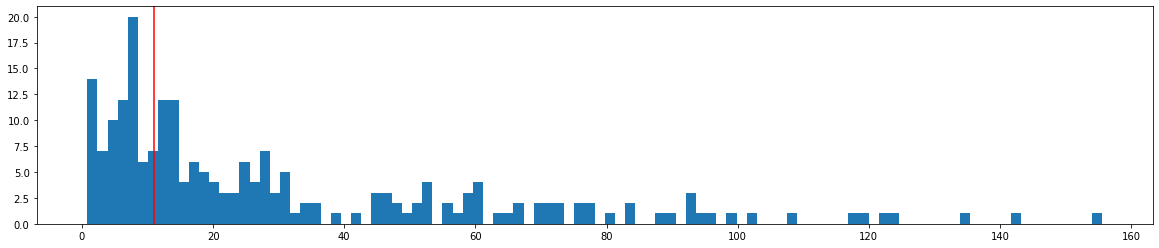

In [ ]:
#calualate potential planet radii to weed out EBs
radii=[]
for i in range(len(df)):
  depth = df['Depth'].iloc[i]
  star_r = df['rad'].iloc[i]
  planet_r = planet_radii(depth,star_r)
  radii.append(planet_r)
jupiter_r = 69.911E6 #m
Earth_r = 6371000 #m
print(jupiter_r)
max_r = jupiter_r / Earth_r
print(max_r)
plt.figure(figsize = (20,4))
plt.hist(radii, bins = 100);
plt.axvline(max_r,color='r');
mask = [i for i in range(len(df)) if radii[i]<max_r]
planets = df.iloc[mask]

len(planets),planets['TIC'].to_numpy()

In [ ]:
#find those planets that are around earth's size
earth2 = []
for count,i in enumerate(radii):
  if i <1.5:
    print(i)
    earth2.append(count)
  else:
    pass
df.iloc[earth2] #62,63,100, 101 some but no r, 149, 216 are all unknown R or unknown planets; others are planets w larger r

1.0703717935587862
1.2898037734088994
1.1275784648994374
1.2797473780768704
1.2719664467620708
0.8103114437398563
1.4497206317807787
1.1988562633957207


,ID,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,APASS,KIC,objType,typeSrc,ra,dec,POSflag,pmRA,e_pmRA,pmDEC,e_pmDEC,PMflag,plx,e_plx,PARflag,gallong,gallat,eclong,eclat,Bmag,e_Bmag,Vmag,e_Vmag,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,...,eneg_Rad,epos_Rad,eneg_rho,epos_rho,eneg_logg,epos_logg,eneg_lum,epos_lum,eneg_dist,epos_dist,distflag,eneg_Teff,epos_Teff,TeffFlag,gaiabp,e_gaiabp,gaiarp,e_gaiarp,gaiaqflag,starchareFlag,VmagFlag,BmagFlag,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,objID,ABS Mag,TIC,Period,Duration,Transit Time,Power,Depth,Sector
9,28230919,20190415,97657.0,3561-02092-1,691-070316,19505021+4804508,NaN,NaN,2086512227851023872,54470133.0,10748390.0,STAR,tmgaia2,297.709364,48.080860,tmgaia2,125.98400,0.040610,232.9880,0.044990,gaia2,26.45080,0.023446,gaia2,81.833703,10.772381,321.548036,66.629442,10.556,0.141,9.460,0.030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.051426,0.045157,0.418599,0.455017,0.080525,0.092496,0.009814,0.008251,0.0336,0.0337,bj2018,107.360,118.373,spect,9.74374,0.001652,8.46507,0.001891,1,NaN,hipvmag,apassdr9,NaN,0.689515,0.697757,297.710176,48.081864,0.019271,0.024141,1,0,347873767,6.263174,28230919,0.299916,0.298,0.149,0,0.000166,15
47,148914726,20190415,NaN,4161-00688-1,787-021690,12281343+6714239,1.237651e+18,J122813.41+671423.9,1680911012650126848,59593798.0,NaN,STAR,tmgaia2,187.055970,67.239983,tmgaia2,-6.57786,0.041855,13.8229,0.030823,gaia2,11.53920,0.020012,gaia2,126.401690,49.731583,139.909375,59.876362,11.710,0.131,10.879,0.010,14.7908,0.006373,14.1917,0.009002,13.8403,0.008583,13.0775,0.008261,...,0.037062,0.060576,0.279732,0.577095,0.112325,0.056106,0.007504,0.011244,0.1504,0.1509,bj2018,103.245,140.016,dered0,11.21210,0.002079,10.07900,0.001733,1,NaN,tycho2v3,tycho2b3,NaN,0.779330,0.478005,187.055897,67.240043,0.020030,0.015425,1,0,145919024,6.021179,148914726,0.301269,0.298,0.158,1,0.000232,15
62,159414803,20190415,NaN,NaN,851-011725,15545327+8010008,1.237657e+18,NaN,1708990478040218112,60918953.0,NaN,STAR,tmgaia2,238.722284,80.166870,tmgaia2,109.67900,0.085969,-275.1480,0.098990,gaia2,22.24510,0.049480,gaia2,114.458301,33.719584,108.964874,74.167327,17.139,0.000,16.170,0.200,19.3038,0.030838,16.4108,0.004020,14.9171,0.004145,18.0541,0.021912,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1002,0.1007,bj2018,NaN,NaN,cdwrf,15.83120,0.003488,13.12220,0.001310,1,NaN,cdwrf,apassdr9,cooldwarfs_v8,1.742233,1.535139,238.725049,80.165685,0.047327,0.049332,1,0,157451784,11.058972,159414803,0.299916,0.298,0.153,0,0.001447,15
63,159613900,20190415,71631.0,4176-00540-1,772-037433,14390026+6417299,NaN,J143859.99+641729.9,1668690628102524672,NaN,NaN,STAR,tmgaia2,219.750879,64.291660,tmgaia2,-135.99100,0.066402,-36.9388,0.058838,gaia2,29.02740,0.027040,gaia2,105.516052,49.040101,162.695745,69.554117,8.244,0.024,7.600,0.030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.049529,0.057125,0.220151,0.250241,0.075426,0.084442,0.018004,0.025790,0.0322,0.0323,bj2018,149.163,125.359,spect,7.86811,0.003959,6.99310,0.004360,1,NaN,hipvmag,tycho2b3,NaN,1.215891,0.912381,219.749529,64.291501,0.027442,0.026793,1,0,152297497,4.810991,159613900,0.315141,0.298,0.173,11,0.000141,14
100,219739171,20190415,NaN,4189-00836-1,756-047714,16073279+6105539,1.237672e+18,J160732.73+610554.8,1626830021410028160,58331312.0,NaN,STAR,tmgaia2,241.886603,61.098366,tmgaia2,-34.32430,0.042704,61.6304,0.059043,gaia2,8.40624,0.022351,gaia2,93.033668,42.940102,190.661699,76.600245,11.410,0.106,10.705,0.007,14.5170,0.006855,11.3149,0.000601,10.5270,0.000387,10.3576,0.000696,...,0.043379,0.046390,0.236279,0.410978,0.088727,0.067124,0.018304,0.016048,0.3160,0.3170,bj2018,127.441,118.988,dered,10.86150,0.001662,9.98269,0.001300,1,NaN,tycho2v3,tycho2b3,NaN,0.768872,0.915539,241.886297,61.098632,0.020670,0.026052,1,0,158654141,5.110709,219739171,0.303994,0.298,0.152,3,0.000177,15
101,219792161,20190415,86456.0,4207-00164-1,776-034902,17395569+6500057,NaN,J173955.66+650007.0,1440964624481230464,59364130.0,NaN,STAR,tmgaia2,2

# End radii work

In [ ]:
olivia = df.iloc[145:158] #[0:31]
maria = df.iloc[31:63]
ac = df.iloc[63:95]
sarah = df.iloc[95:127] 
elise = df.iloc[127:145] #[127:158] 
eliza = df.iloc[158:175] #[158:190]
dee = df.iloc[175:190] #[190::]
dee

,ID,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,APASS,KIC,objType,typeSrc,ra,dec,POSflag,pmRA,e_pmRA,pmDEC,e_pmDEC,PMflag,plx,e_plx,PARflag,gallong,gallat,eclong,eclat,Bmag,e_Bmag,Vmag,e_Vmag,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,...,eneg_Rad,epos_Rad,eneg_rho,epos_rho,eneg_logg,epos_logg,eneg_lum,epos_lum,eneg_dist,epos_dist,distflag,eneg_Teff,epos_Teff,TeffFlag,gaiabp,e_gaiabp,gaiarp,e_gaiarp,gaiaqflag,starchareFlag,VmagFlag,BmagFlag,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,objID,ABS Mag,TIC,Period,Duration,Transit Time,Power,Depth,Sector
175,303833577,20190415,NaN,3581-01856-1,696-080848,20355718+4900425,NaN,J203557.13+490042.1,2179794175880486272,54523001.0,NaN,STAR,tmgaia2,308.988261,49.011795,tmgaia2,-38.197800,0.051411,-50.08820,0.045246,gaia2,7.82140,0.029060,gaia2,86.695248,4.997984,337.909421,63.553429,11.978,0.173,10.929,0.016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.051800,0.108576,0.149139,0.261115,0.079090,0.127862,0.029162,0.033930,0.473,0.477,bj2018,180.126,147.605,dered,11.24690,0.024768,10.13880,0.022387,1,NaN,tycho2v3,tycho2b3,NaN,0.876101,0.701766,308.988010,49.011579,0.024460,0.025000,1,0,411535069,5.227422,303833577,0.695948,0.042,0.370,187,0.053895,15
176,305386053,20190415,NaN,3188-01369-1,655-104888,21483373+4058363,NaN,J214833.74+405836.4,1960281592830251136,51920947.0,NaN,STAR,tmgaia2,327.140607,40.976759,tmgaia2,-4.398620,0.035350,10.92530,0.040742,gaia2,1.57489,0.026255,gaia2,89.667874,-9.794077,349.722919,49.870039,12.842,0.414,12.732,0.036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.096518,0.088653,0.054774,0.041976,0.104015,0.077963,0.610484,0.284827,10.127,10.460,bj2018,156.778,215.182,dered,12.87600,0.006040,11.93420,0.005766,1,NaN,tycho2v3,tycho2b3,NaN,0.585175,0.631863,327.140582,40.976806,0.016967,0.021336,1,0,461696511,3.471151,305386053,1.243844,0.074,0.351,316,0.226771,15
177,309720946,20190415,NaN,3852-00130-1,719-053088,14130968+5337547,1.237661e+18,J141309.68+533754.8,1608302082250699648,56246338.0,NaN,STAR,tmgaia2,213.290364,53.631931,tmgaia2,0.118006,0.039937,-6.22378,0.035691,gaia2,1.11948,0.022258,gaia2,98.856214,59.508890,177.494817,60.255200,13.135,0.417,12.057,0.038,14.5665,0.005138,12.8753,0.001286,12.3584,0.001368,12.2599,0.001548,...,0.108767,0.154128,0.021462,0.020515,0.095028,0.088250,0.417222,0.392595,16.674,17.326,bj2018,126.816,157.580,spect,12.50290,0.001260,11.82330,0.000957,1,NaN,tycho2v3,tycho2b3,NaN,0.693889,0.553481,213.290365,53.631905,0.019434,0.017290,1,0,150902062,2.483682,309720946,2.304595,0.106,0.936,453,0.121729,15
178,311945765,20190415,NaN,3155-01619-1,654-088396,20130085+4038414,NaN,J201300.85+403840.8,2062485287453921280,51794921.0,5499914.0,STAR,tmgaia2,303.253570,40.644843,tmgaia2,-13.076700,0.041099,-32.76110,0.043305,gaia2,2.27505,0.026414,gaia2,77.488483,3.536927,322.171999,58.213256,12.651,0.440,12.796,0.051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.081383,0.084541,0.097109,0.093458,0.101825,0.073468,0.074874,0.081082,4.959,5.073,bj2018,157.886,147.462,dered,12.54990,0.021550,11.69490,0.017563,1,NaN,tycho2v3,tycho2b3,NaN,0.679605,0.671644,303.253496,40.644702,0.019403,0.023776,1,0,388845171,3.993055,311945765,0.498781,0.042,0.373,113,0.151198,14
179,311945765,20190415,NaN,3155-01619-1,654-088396,20130085+4038414,NaN,J201300.85+403840.8,2062485287453921280,51794921.0,5499914.0,STAR,tmgaia2,303.253570,40.644843,tmgaia2,-13.076700,0.041099,-32.76110,0.043305,gaia2,2.27505,0.026414,gaia2,77.488483,3.536927,322.171999,58.213256,12.651,0.440,12.796,0.051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.081383,0.084541,0.097109,0.093458,0.101825,0.073468,0.074874,0.081082,4.959,5.073,bj2018,157.886,147.462,dered,12.54990,0.021550,11.69490,0.017563,1,NaN,tycho2v3,tycho2b3,NaN,0.679605,0.671644,303.253496,40.644702,0.019403,0.023776,1,0,388845171,3.993055,311945765,0.498781,0.042,0.251,113,0.150512,15
180,316450573,20190415,NaN,4176-00752-1,769-041534,14470170+6343372,NaN,J144701.70+634337.3,1620521023689704832,58624337.0,NaN,STAR,tmg

In [ ]:
#put into custom class

count = 14

# tics = dee['TIC'].to_numpy() #all targets
# tic = tics[count] #target I'm looking at
tic =  160585813

sector = 14 
mydata = [tic,sector] #format data to fit into our custom class

starclass = lca.LCAnalysis(mydata) #initate class
starclass #verify its a class object now

TIC: 160585813

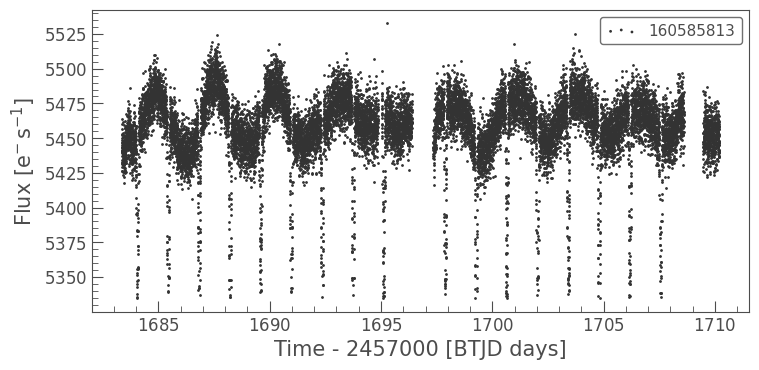

In [ ]:

%matplotlib inline
lc = starclass.open_clean_lc()
lc.scatter()




66    0.007119
67    0.005801
Name: Depth, dtype: float64
estimated planet radius: 24.49860230894217


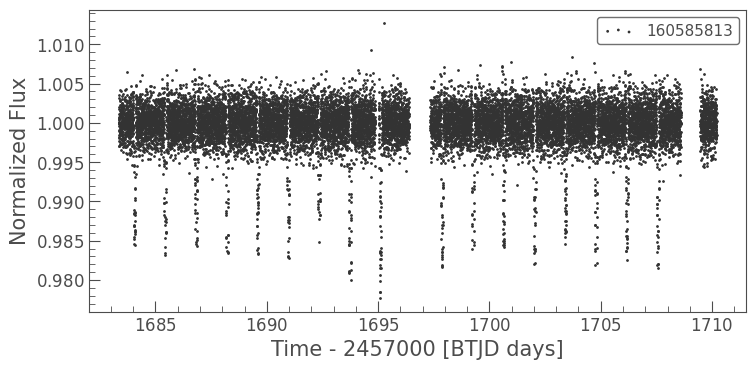

In [ ]:
###estimate depth by eye

lcnorm = lc.normalize()
lcflat = lcnorm.flatten()
target_df = df[df['TIC']==tic] #dee[dee['TIC']==tic]
bls_depth =  .015# target_df['Depth'].to_numpy()[0]
star_r = target_df['rad'].to_numpy()[0]
print(target_df['Depth'])
est_radius = planet_radii(bls_depth, star_r)
print('estimated planet radius:', est_radius)
lcflat.scatter()
# plt.xlim(1685.1,1685.4)

In [ ]:
# tic = 28230919
mytest = df[df['TIC']==tic]
mytest[['TIC','Period','Duration','Power','Depth','Sector']]

,TIC,Period,Duration,Power,Depth,Sector
66,160585813,1.379525,0.106,339,0.007119,14
67,160585813,1.379525,0.106,339,0.005801,15


1.38


[]

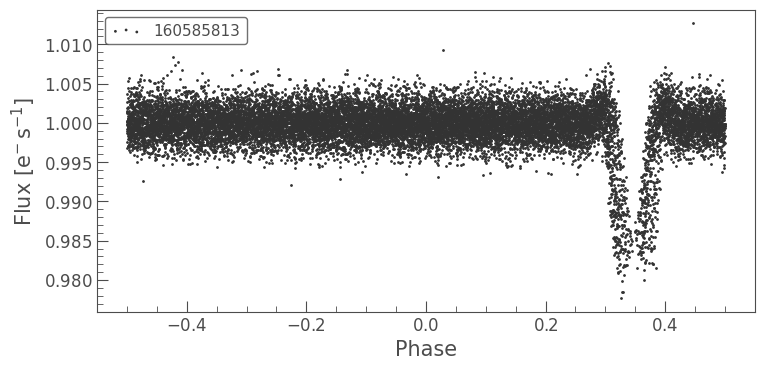

In [ ]:
# period = dee['Period'].iloc[count]
period = 1.38  # df['Period'].iloc[mytest.index]
print(period)
folded_lc = starclass.folded(period)
folded_lc.plot()
# plt.xlim(0,0.2)

In [ ]:
list(dee.columns)
dee['rad']

NameError: ignored

In [ ]:
df[df['TIC']==233120979]

,ID,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,APASS,KIC,objType,typeSrc,ra,dec,POSflag,pmRA,e_pmRA,pmDEC,e_pmDEC,PMflag,plx,e_plx,PARflag,gallong,gallat,eclong,eclat,Bmag,e_Bmag,Vmag,e_Vmag,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,...,eneg_Rad,epos_Rad,eneg_rho,epos_rho,eneg_logg,epos_logg,eneg_lum,epos_lum,eneg_dist,epos_dist,distflag,eneg_Teff,epos_Teff,TeffFlag,gaiabp,e_gaiabp,gaiarp,e_gaiarp,gaiaqflag,starchareFlag,VmagFlag,BmagFlag,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,objID,ABS Mag,TIC,Period,Duration,Transit Time,Power,Depth,Sector
